## Initial Cleaning and Exploration

In [2]:
%matplotlib inline
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
df = pd.read_csv("top250-00-19.csv")
df.head()

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


In [3]:
#mean age of players in the data
rows = df.shape[0]
age_sum = sum(df['Age'])
mean_age = age_sum / rows
print(mean_age)

24.33872340425532


In [4]:
print(rows)

4700


In [5]:
most_expensive = df[df['Transfer_fee'] == df['Transfer_fee'].max()]
most_expensive

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
4211,Neymar,Left Winger,25,FC Barcelona,LaLiga,Paris SG,Ligue 1,2017-2018,100000000.0,222000000


I've loaded in the dataset and done some initial exploration here. Not surprisingly, Neymar's transfer to PSG is the most expensive one in the dataset.

In [6]:
mean_fee=df.groupby('Team_to')['Transfer_fee'].mean().rename('Mean_fee')
count_transfers=df.groupby('Team_to')['Transfer_fee'].size().rename('Transfer_count')
biggest_avg_spender = pd.concat([mean_fee, count_transfers], axis=1).reset_index()
biggest_avg_spender.nlargest(10, 'Mean_fee')

,Team_to,Mean_fee,Transfer_count
257,SIPG,2.598333e+07,6
110,FC Barcelona,2.390057e+07,70
70,CC Yatai,2.330000e+07,1
194,Man Utd,2.303631e+07,65
243,Real Madrid,2.240867e+07,75
221,Paris SG,1.931485e+07,66
192,Man City,1.915447e+07,94
83,Chelsea,1.896510e+07,96
165,Juventus,1.690736e+07,87
184,Liverpool,1.661671e+07,85


The top ten largest average spenders are shown above. SIPG and CC Yatai are both Chinese clubs that I'm not very familiar with, but their transfer count also isn't that high so I won't look into their inclusion too much. Besides those two clubs, there aren't really any surprises in this list.

In [7]:
league_to = df['League_to']
count = league_to.value_counts()
count['other'] = sum(count[11:])
count.sort_values(ascending=False)
filtered_counts = count[count > 72]
filtered_counts.rename('League')
#Counts of what leagues transfers go to

Premier League    1256
Serie A            739
LaLiga             525
1.Bundesliga       422
Ligue 1            397
Premier Liga       328
Süper Lig          143
Liga NOS           127
Super League       122
Eredivisie         108
other              461
Name: League, dtype: int64

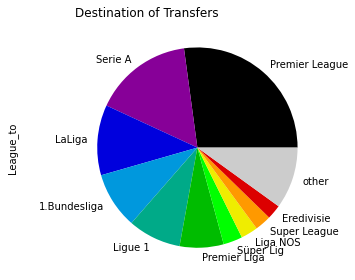

In [8]:
colormap = plt.cm.nipy_spectral
filtered_counts.plot(kind="pie", colormap=colormap, title="Destination of Transfers")
left, right = plt.xlim()
plt.xlim(left - 0.5, right - 0.5)
plt.tight_layout()
plt.show()


In [9]:
league_from = df["League_from"]
count = league_from.value_counts()
count['other'] = sum(count[11:])
count.sort_values(ascending=False)
filtered_counts = count[count > 100]
filtered_counts.rename('League')
#Counts of what leagues transfers come from

Premier League     608
Serie A            602
Ligue 1            428
LaLiga             418
1.Bundesliga       265
Série A            199
Championship       197
Eredivisie         190
Liga NOS           178
Premier Liga       169
Super League       108
other             1338
Name: League, dtype: int64

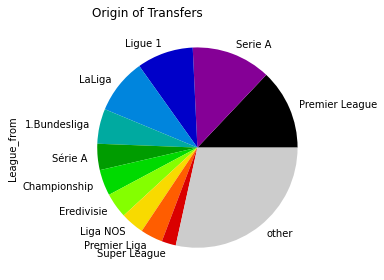

In [10]:
colormap = plt.cm.nipy_spectral
filtered_counts.plot(kind="pie", colormap=colormap, title="Origin of Transfers")
left, right = plt.xlim()
plt.xlim(left - 0.5, right - 0.5)
plt.tight_layout()
plt.show()

The two pie charts above show the destination and origin of the transfers. The first chart shows that the majority of the most expensive transfers go to the traditional top 5 leagues, with the premier league having the greatest percentage. The second pie chart shows the origin of the transfers is similar to the destinations, except that the smaller leagues take up a greater percentage. This makes sense logically, as while many top clubs buy players from other top leagues, they also frequently buy players from smaller leagues. However, it is less common for a club from a smaller league to buy a player from a top league.

## Data Aggregating

Now I do some more data cleaning. There are many similar positions listed in the dataset, so I am going to group similar positions together, such as Left-Winger and Left-Midfielder in order to get a simpler dataset with less different positions.

In [11]:
#Now we will explore the average cost based on position
df['Position'].value_counts()

Centre-Forward        1218
Centre-Back            714
Central Midfield       487
Attacking Midfield     426
Defensive Midfield     411
Right Winger           305
Left Winger            267
Left-Back              225
Right-Back             181
Goalkeeper             180
Second Striker         130
Left Midfield           87
Right Midfield          63
Forward                  3
Defender                 1
Midfielder               1
Sweeper                  1
Name: Position, dtype: int64

In [12]:
#Clean the data to group similar positions together
df.loc[df.Position == 'Left Winger', 'Position'] = 'Left Midfield'
df.loc[df.Position == 'Second Striker', 'Position'] = 'Centre-Forward'
df.loc[df.Position == 'Right Winger', 'Position'] = 'Right Midfield'
df.loc[df.Position == 'Sweeper', 'Position'] = 'Centre-Back'
df.loc[df.Position == 'Defender', 'Position'] = 'Centre-Back'
df.loc[df.Position == 'Midfielder', 'Position'] = 'Central Midfield'
df.loc[df.Position == 'Forward', 'Position'] = 'Centre-Forward'
df['Position'].value_counts()

Centre-Forward        1351
Centre-Back            716
Central Midfield       488
Attacking Midfield     426
Defensive Midfield     411
Right Midfield         368
Left Midfield          354
Left-Back              225
Right-Back             181
Goalkeeper             180
Name: Position, dtype: int64

In [13]:
average_costs = df.groupby('Position', as_index=False)['Transfer_fee'].mean()
print(average_costs)

             Position  Transfer_fee
0  Attacking Midfield  9.824178e+06
1    Central Midfield  1.007787e+07
2         Centre-Back  8.430929e+06
3      Centre-Forward  9.496869e+06
4  Defensive Midfield  8.992019e+06
5          Goalkeeper  7.622667e+06
6       Left Midfield  1.138398e+07
7           Left-Back  7.718933e+06
8      Right Midfield  1.115549e+07
9          Right-Back  8.254309e+06


## Visualizations

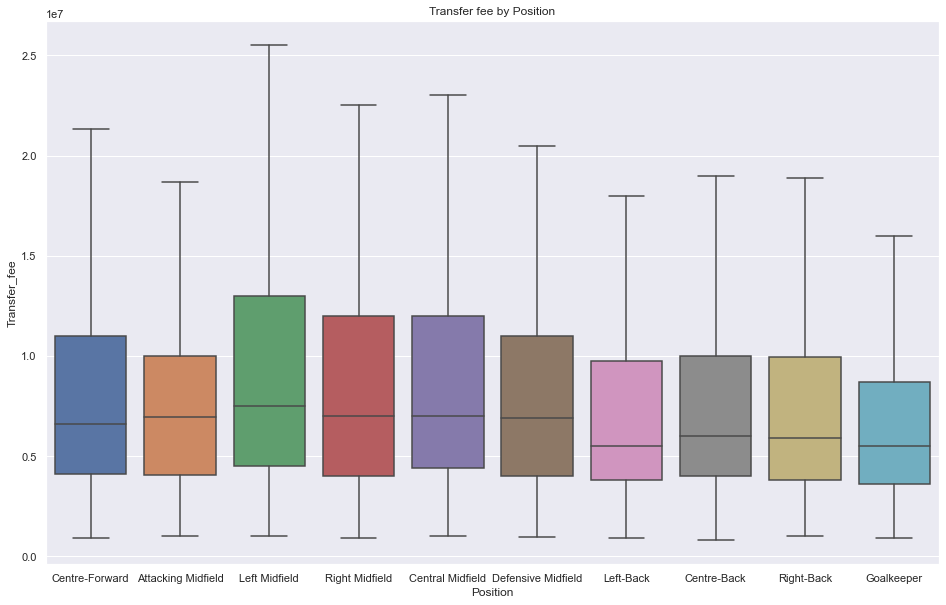

In [14]:
sns.set(rc={'figure.figsize':(16,10)})
sns.boxplot(x='Position', y='Transfer_fee',data=df[['Position', 'Transfer_fee']], order=["Centre-Forward", "Attacking Midfield", "Left Midfield","Right Midfield","Central Midfield",
                                   "Defensive Midfield", "Left-Back", "Centre-Back", "Right-Back", "Goalkeeper"], showfliers=False).set_title("Transfer fee by Position")
None

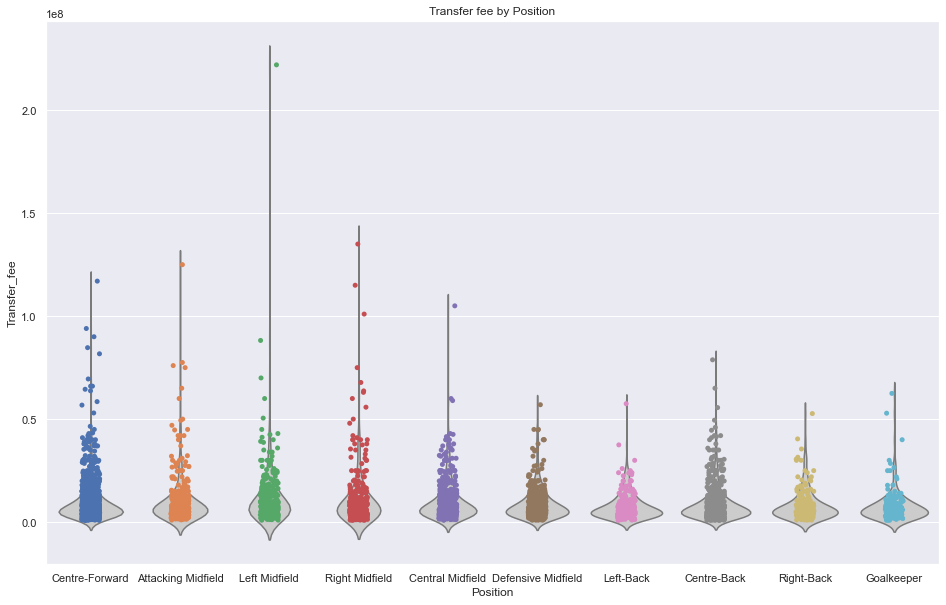

In [15]:
ax = sns.violinplot(x='Position', y='Transfer_fee', data=df[['Position', 'Transfer_fee']],
                    inner=None, color=".8", order=["Centre-Forward", "Attacking Midfield", "Left Midfield","Right Midfield","Central Midfield",
                                   "Defensive Midfield", "Left-Back", "Centre-Back", "Right-Back", "Goalkeeper"])
ax = sns.stripplot(x='Position', y='Transfer_fee', data=df[['Position', 'Transfer_fee']], order=["Centre-Forward", "Attacking Midfield", "Left Midfield","Right Midfield","Central Midfield",
                                   "Defensive Midfield", "Left-Back", "Centre-Back", "Right-Back", "Goalkeeper"])
ax.set_title("Transfer fee by Position")
None

The two cells above both show the average transfer fee by position in similar but slightly different ways. They both show the mean and convey information about the spread of the data, but the width of the base oval in the second plot also conveys the variance of transfer fees for each position. It's not very surprising that attackers (particularly the most elite ones) generally cost more than defenders. 

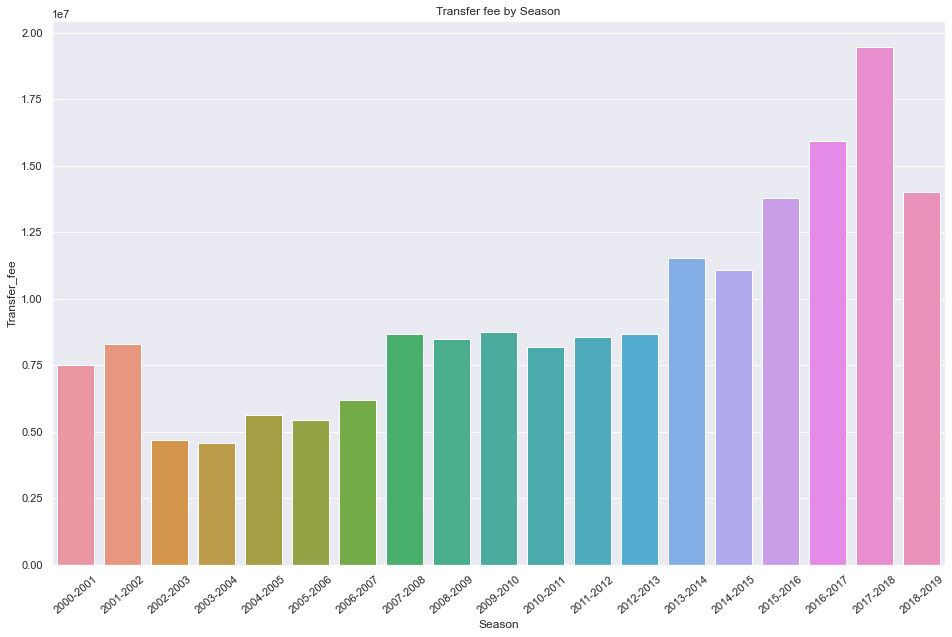

In [16]:
sns.barplot(x='Season', y='Transfer_fee', data=df[['Season', 'Transfer_fee']],
            ci=None).set_title('Transfer fee by Season')
plt.xticks(rotation=40)
None

This bar chart shows the average transfer fee by each season without going into any further detail. Transfer fees clearly rose over time, despite taking slight dips or pauses during periods of economic downturn, such as the dot com burst and and great recession.

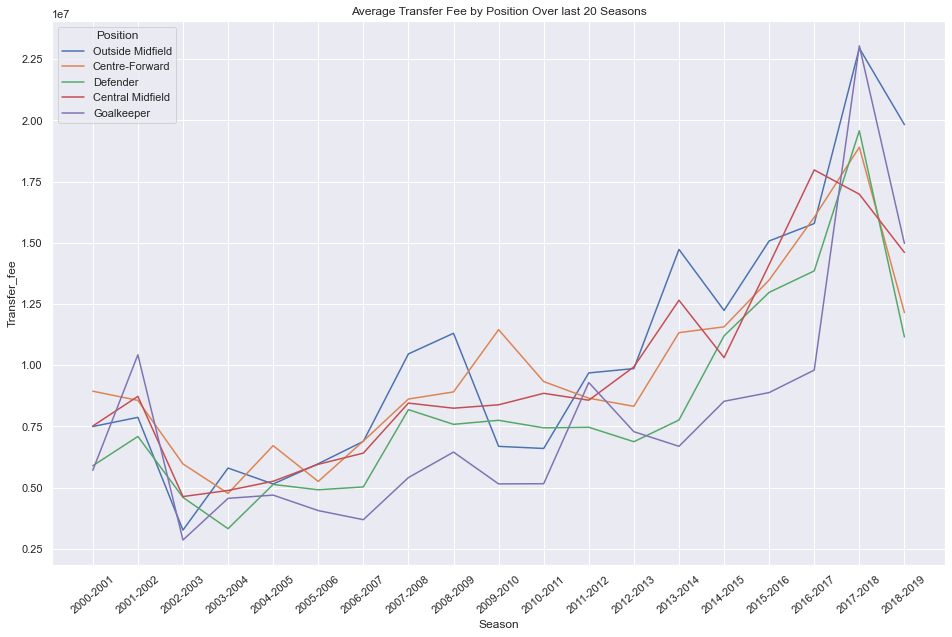

In [95]:
simplified = df.copy()
simplified.loc[simplified.Position == 'Right Midfield', 'Position'] = 'Outside Midfield'
simplified.loc[simplified.Position == 'Left Midfield', 'Position'] = 'Outside Midfield'
simplified.loc[simplified.Position == 'Attacking Midfield', 'Position'] = 'Central Midfield'
simplified.loc[simplified.Position == 'Defensive Midfield', 'Position'] = 'Central Midfield'
simplified.loc[simplified.Position == 'Centre-Back', 'Position'] = 'Defender'
simplified.loc[simplified.Position == 'Left-Back', 'Position'] = 'Defender'
simplified.loc[simplified.Position == 'Right-Back', 'Position'] = 'Defender'
sns.lineplot(x='Season', y='Transfer_fee',
                 data=simplified[['Season', 'Transfer_fee', 'Position']],
                 hue='Position', ci=None).set_title('Average Transfer Fee by Position Over last 20 Seasons')

plt.xticks(rotation=40)
None

The above chart further breaks down how transfer fees have changed over the season by position. Different trends in each position are very interesting, such as goalkeeper and defender consistently remaining lower than some of the more attacking positions.

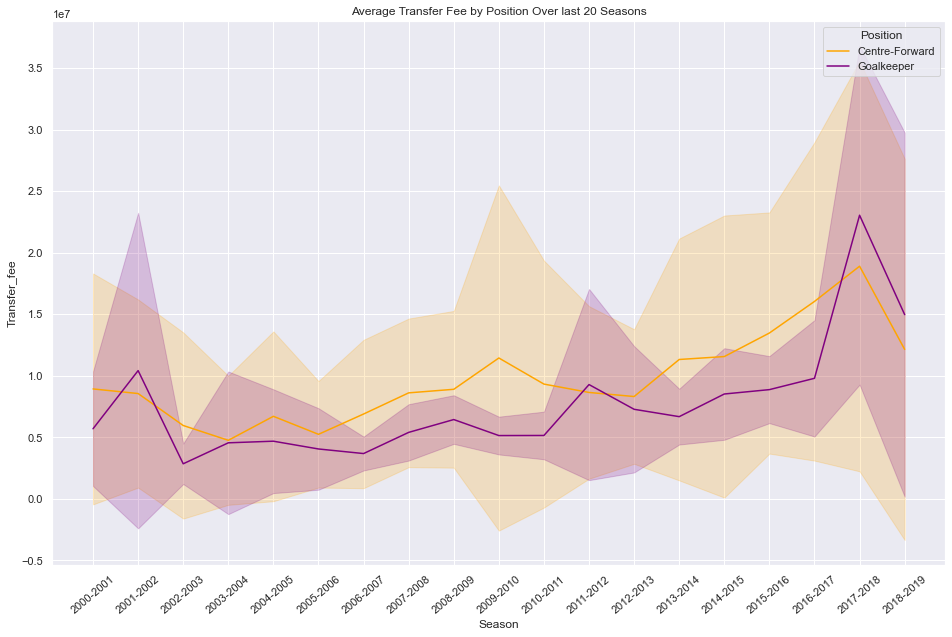

In [102]:
fsim = simplified[(simplified['Position'] == 'Goalkeeper') | (simplified['Position'] == 'Centre-Forward')]
sns.lineplot(x='Season', y='Transfer_fee',
                 data=fsim[['Season', 'Transfer_fee', 'Position']],
                 hue='Position',
                 palette = {'Goalkeeper': 'Purple', 'Centre-Forward': 'Orange'
                           }, ci='sd').set_title('Average Transfer Fee by Position Over last 20 Seasons')

plt.xticks(rotation=40)
None

For reference, the plot shown above is the same as the previous one, except for two changes. I have shown an error bound (1 standard deviation) around each line and have only included the lines for goalkeeper and centre-forward. I wanted to give some reference for the error, but didn't want to include them all on the original plot because as you can see, even with only two lines and error bounds, the plot looks quite hectic.

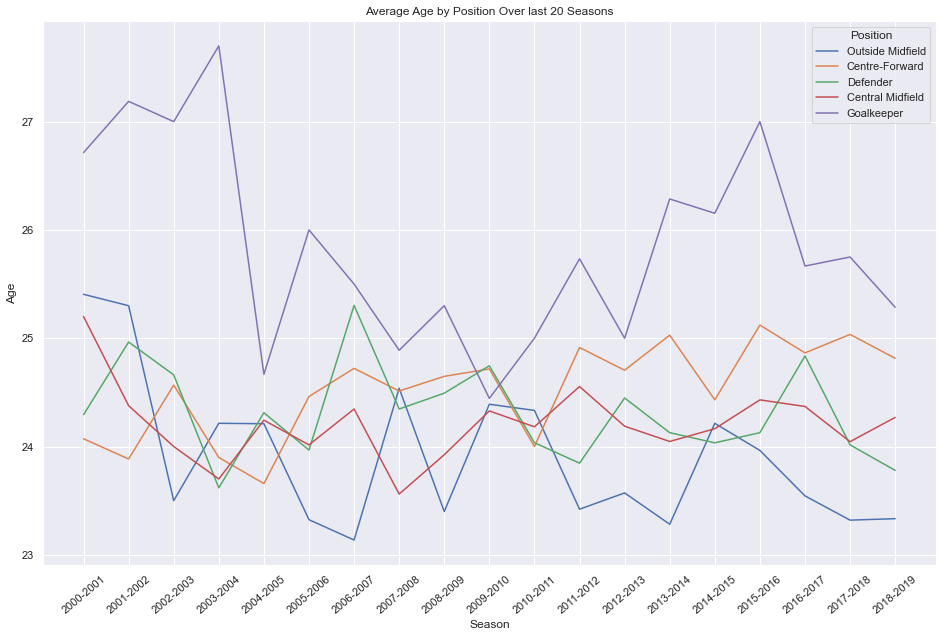

In [18]:
sns.lineplot(x='Season', y='Age',
                 data=simplified[['Season', 'Age', 'Position']],
                 hue='Position', ci=None).set_title('Average Age by Position Over last 20 Seasons')

plt.xticks(rotation=40)
None

The chart above shows the average age of the trasnfers in each position for each season. Not surprisingly, goalkeepers are generally much older than other positions, as they can play until they are much older and generally also take longer to reach the prime of their career (when their transfer fee would be the greatest). Another interesting trend is that in recent years, centre-forwards have been older than outside midfielders. Perhaps teams prefer slightly more experience for their centre-forwards, but are willing to gamble on younger players at the outside midfield position.

In [19]:
sum_spent = df.groupby(['Team_to', 'Season'])['Transfer_fee'].sum().reset_index()
prem_top_6 = sum_spent[sum_spent['Team_to'].isin(['Arsenal', 'Chelsea', 'Man Utd', 'Man City', 'Liverpool', 'Spurs'])]
prem_top_6 = prem_top_6.rename({'Transfer_fee': 'Total_Spent'}, axis='columns')
prem_top_6.head()

,Team_to,Season,Total_Spent
145,Arsenal,2000-2001,53300000
146,Arsenal,2001-2002,31250000
147,Arsenal,2002-2003,10730000
148,Arsenal,2003-2004,30250000
149,Arsenal,2004-2005,11700000


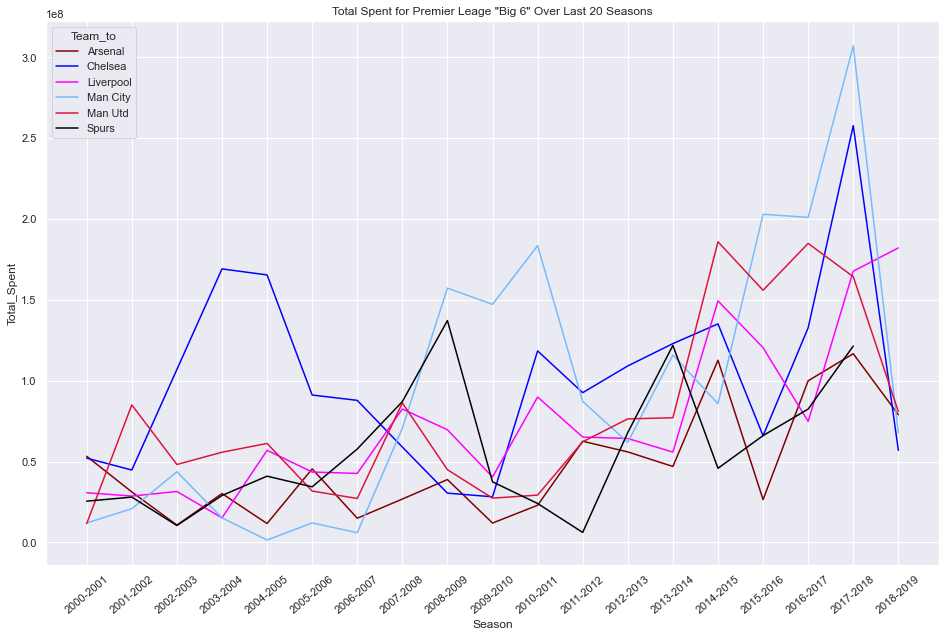

In [20]:
sns.lineplot(x='Season', y='Total_Spent',
             data = prem_top_6[['Team_to', 'Season', 'Total_Spent']],
             hue='Team_to',
             palette = {'Arsenal':'Maroon', 'Chelsea': 'Blue', 'Man Utd': 'Crimson',
                        'Man City': 'xkcd:sky blue', 'Liverpool': 'Magenta', 'Spurs': 'Black'},
             ci=None).set_title('Total Spent for Premier Leage "Big 6" Over Last 20 Seasons')
plt.xticks(rotation=40)
None

This is my favorite chart, as I am especially a fan of the English Premier League. This chart shows the total spent by the traditional 'big 6' clubs over the last 19 seasons. I feel that this chart shows, more than anything, that it takes significant spending to be successful in the Premier League. We can see spending spikes from Chelsea just before they started becoming successful in the mid 2000s and also very recently. We can also see a significant spending spike from Manchester City just before they began their period of sustained success in the mid 2010s. Similar spikes exist for Liverpool and Manchester United. However, spending also does not guarantee success, as there are a number of spikes from Spurs and Arsenal, but both teams have had limited success in recent years. One trend that I find particularly interesting is how Arsenal (my favorite team) consistently spend less than their 'big 6' rivals. This trend backs up the sentiment that many Arsenal fans feel, that their owners do not spend enough money for them to be competitive.

#### Sankey Diagram of Transfer Flow

Another aspect of the data that I wanted to visualize was the flow of transfers between leagues. The perfect way to do this is a Sankey diagram shown a few cells below. First, I group the transfers by the League_from and League_to and combine all the rows in which these are the same by summing the Transfer_fee. This gives me one total amount of money going from one league to another. Thus, the data is now prepared for the Sankey Flow Diagram.

In [30]:
sank_df = simplified.copy()
sank_df = sank_df[['League_from', 'League_to', 'Transfer_fee']]
sank_df['League_from'] = 'f_' + sank_df['League_from'].astype(str)
sank_df['League_to'] = 't_' + sank_df['League_to'].astype(str)
sank_df = sank_df.groupby(['League_from', 'League_to'])['Transfer_fee'].sum().reset_index()
sank_df = sank_df.sort_values(by=['Transfer_fee'], ascending=False)
sank_df.head()

,League_from,League_to,Transfer_fee
450,f_Premier League,t_Premier League,4527910000
530,f_Serie A,t_Serie A,3889690000
311,f_LaLiga,t_LaLiga,1680010000
318,f_LaLiga,t_Premier League,1645660000
410,f_Ligue 1,t_Premier League,1589510000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Sankey   [League_from,League_to]   (Transfer_fee)
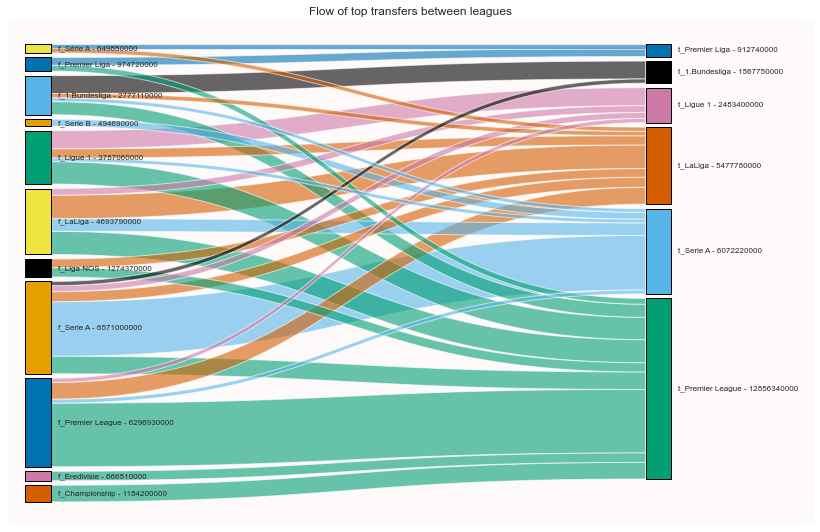

In [94]:
import holoviews as hv
from holoviews import dim, opts
hv.extension("matplotlib")
sankey1 = hv.Sankey(sank_df.head(30), kdims=["League_from", "League_to"], vdims=["Transfer_fee"]).opts(opts.Sankey(
label_position='right', color_levels = 30, cmap='Colorblind',symmetric=False,
                                     node_alpha=1.0, node_width=40, node_sort=True,
                                     bgcolor="snow",
                                     edge_color='League_to', node_color='index',
                                     title="Flow of top transfers between leagues"
)
)
sankey1

The Sankey diagram above shows the flow of money from leagues on the left to leagues on the right, in which the bigger a connection/route is, the more money is flowing through that connection/route. This shows some very interesting information. Unsurprisingly, the Premier League spends the most money by quite a bit. It also draws in top talent from all of the other major leagues in quite significant amounts. La Liga and Serie A are similar to the Premier League in that they pull talent from many different leagues, but they spend less money overall. The Bundesliga, on the other hand, appears to rarely spend large amounts of money on talent from other leagues, preferring to buy players from within the league.

:Sankey   [League_from,League_to]   (Transfer_fee)
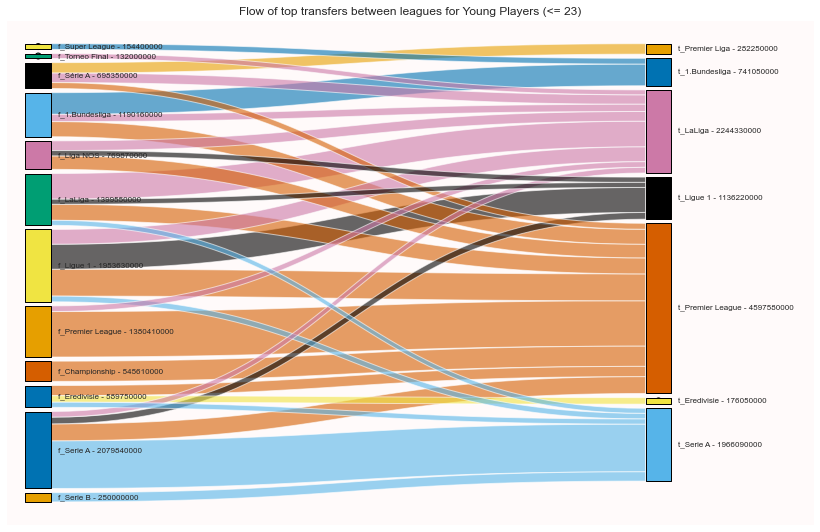

In [103]:
sank_df = simplified.copy()
sank_df = sank_df[sank_df['Age'] <= 23]
sank_df = sank_df[['League_from', 'League_to', 'Transfer_fee']]
sank_df['League_from'] = 'f_' + sank_df['League_from'].astype(str)
sank_df['League_to'] = 't_' + sank_df['League_to'].astype(str)
sank_df = sank_df.groupby(['League_from', 'League_to'])['Transfer_fee'].sum().reset_index()
sank_df = sank_df.sort_values(by=['Transfer_fee'], ascending=False)
sankey1 = hv.Sankey(sank_df.head(30), kdims=["League_from", "League_to"], vdims=["Transfer_fee"]).opts(opts.Sankey(
label_position='right', color_levels = 30, cmap='Colorblind',symmetric=False,
                                     node_alpha=1.0, node_width=40, node_sort=True,
                                     bgcolor="snow",
                                     edge_color='League_to', node_color='index',
                                     title="Flow of top transfers between leagues for Young Players (<= 23)"
)
)
sankey1

The chart shown above is the same as before, except this time only for players 23 or younger. It is somewhat similar to the previous chart, except we do tend to see each league target different leagues more than they had in the overall version. For example, it appears that the Premier League buys young players from other leagues much more than it does from within the Premier League.

:Sankey   [League_from,League_to]   (Transfer_fee)
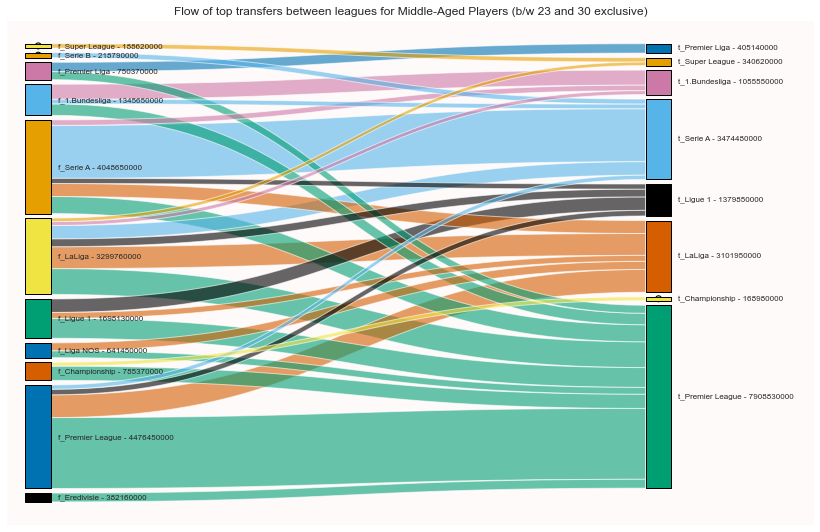

In [105]:
sank_df = simplified.copy()
sank_df = sank_df[(sank_df['Age'] > 23) & (sank_df['Age'] < 30)]
sank_df = sank_df[['League_from', 'League_to', 'Transfer_fee']]
sank_df['League_from'] = 'f_' + sank_df['League_from'].astype(str)
sank_df['League_to'] = 't_' + sank_df['League_to'].astype(str)
sank_df = sank_df.groupby(['League_from', 'League_to'])['Transfer_fee'].sum().reset_index()
sank_df = sank_df.sort_values(by=['Transfer_fee'], ascending=False)
sankey1 = hv.Sankey(sank_df.head(30), kdims=["League_from", "League_to"], vdims=["Transfer_fee"]).opts(opts.Sankey(
label_position='right', color_levels = 30, cmap='Colorblind',symmetric=False,
                                     node_alpha=1.0, node_width=40, node_sort=True,
                                     bgcolor="snow",
                                     edge_color='League_to', node_color='index',
                                     title="Flow of top transfers between leagues for Middle-Aged Players (b/w 23 and 30 exclusive)"
)
)
sankey1

Above we can see the same type of chart, but this time for players between 23 and 30 (exclusive). We do tend to see the same general trends with a few minor differences. One difference that is noticable immediately is that in comparison to the previous chart containing young players, we see that LaLiga spends more money on young players than Serie A and Serie A spends more on middle-aged players than LaLiga. 

:Sankey   [League_from,League_to]   (Transfer_fee)
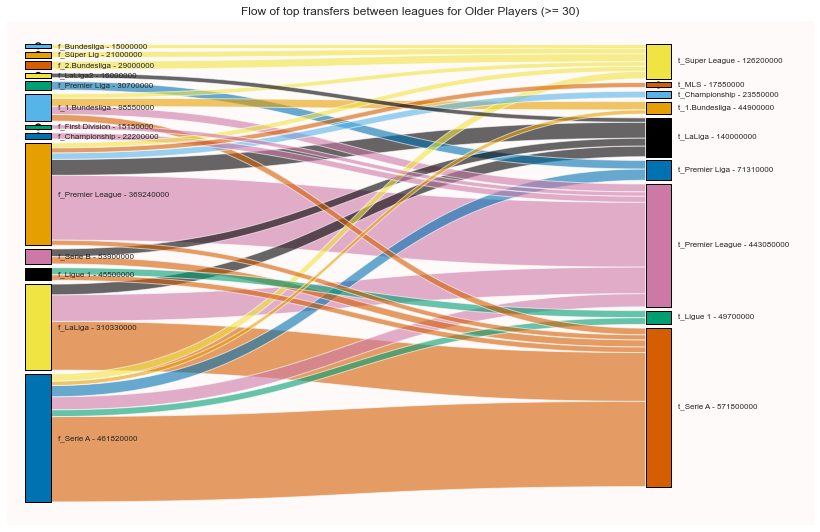

In [106]:
sank_df = simplified.copy()
sank_df = sank_df[sank_df['Age'] >= 30]
sank_df = sank_df[['League_from', 'League_to', 'Transfer_fee']]
sank_df['League_from'] = 'f_' + sank_df['League_from'].astype(str)
sank_df['League_to'] = 't_' + sank_df['League_to'].astype(str)
sank_df = sank_df.groupby(['League_from', 'League_to'])['Transfer_fee'].sum().reset_index()
sank_df = sank_df.sort_values(by=['Transfer_fee'], ascending=False)
sankey1 = hv.Sankey(sank_df.head(30), kdims=["League_from", "League_to"], vdims=["Transfer_fee"]).opts(opts.Sankey(
label_position='right', color_levels = 30, cmap='Colorblind',symmetric=False,
                                     node_alpha=1.0, node_width=40, node_sort=True,
                                     bgcolor="snow",
                                     edge_color='League_to', node_color='index',
                                     title="Flow of top transfers between leagues for Older Players (>= 30)"
)
)
sankey1

This chart, the flow of transfers for players older than 29, is very interesting in comparison to the others. We can immediately see that Serie A spends a lot more money on older, experienced players than other leagues like La Liga or Ligue 1. We also see more purchases from smaller, lesser-known leagues such as the MLS and Super League (the original data source does not differentiate between different leagues called Super League, so this includes the Greek Super League and the Belgian Super League).

---

## Machine Learning
I will now build a number of machine learning models to predict a player's transfer fee from all of the other data we have on the transfer. I will first use classification to approach this problem, by predicting a bucketed range that the transfer fee will fall into. I will then use regression to try to predict the exact transfer fee rather than a bucketed range.

I will first use classification to develop a machine learning model capable of predicting a player's transfer fee based on the other attributes (besides name for obvious reasons and market value due to presence of a lot of Nan's).

In [20]:
class_df = df.drop(columns=["Name", "Market_value"])
class_df.head()

,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee
0,Right Midfield,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,60000000
1,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,56810000
2,Left Midfield,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,40000000
3,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,36150000
4,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,34500000


Now we will add a column showing the bucket a transfer fee falls into. A classification machine learning algorithm cannot predict discrete values and is suited to predicting categorical values. Transfer_fee is obviously a discrete value, so we will use buckets to make this into a categorical value.

In [21]:
class_df["Transfer_fee"].describe()

count    4.700000e+03
mean     9.447586e+06
std      1.043772e+07
min      8.250000e+05
25%      4.000000e+06
50%      6.500000e+06
75%      1.082000e+07
max      2.220000e+08
Name: Transfer_fee, dtype: float64

In [22]:
#params: function to create buckets for the transfer fee where data is the dataframe, and n is the number of buckets
#returns: a new dataframe where "bucket" exists as a column and the "Transfer_fee" column is dropped
def create_buckets(data, n):
    out_df = data.copy()
    out_df["bucket"] = pd.qcut(out_df["Transfer_fee"], q=n)
    out_df = out_df.drop(columns=["Transfer_fee"])
    return out_df

#### Data Encoding

A key problem with this dataset at the moment is that I have lots of categorical variables, but computers only see numbers. Thus, I need to encode my categorical variables to be numerical values. There are two options for each column, label encoding, in which I just assign each unique value in a column a unique number. This works well for ordinal categorical variables such as season because it the assignment of a unique number forces the algorithm to interpret unique relationships in the same order as what you would expect. (i.e. first season gets assigned 0 and second season gets assigned 1). However, this would not work well for something like Position because there is no ordinal relationship there. For columns where there is not an ordinal relationship, I will use one-hot encoding, in which I essentially create a dummy variable for each unique value in the column.

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import patsy as pts

bucketed_df = create_buckets(class_df, 10)

#Label Encoding on Season and Bucket columns
season_le = LabelEncoder()
bucketed_df['Season'] = season_le.fit_transform(bucketed_df['Season'])
target_le = LabelEncoder().fit(bucketed_df['bucket'])
bucketed_df['bucket'] = target_le.transform(bucketed_df['bucket'])

#Performing one-hot encoding on Position, Team_from, League_from, Team_to, and League_to

Y, X = pts.dmatrices('bucket ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = bucketed_df,
                    return_type='dataframe')
None

In [24]:
np_Y = Y['bucket'].to_numpy()

In the code cell below, I scale the data columns to have a mean of 0 and standard deviation of 1. I found that this led to a general improvement in the models performance, which makes sense because many of the columns of the input do not follow a normal distribution and some of them use different scales.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
X.head()

,Intercept,C(Position)[T.Central Midfield],C(Position)[T.Centre-Back],C(Position)[T.Centre-Forward],C(Position)[T.Defensive Midfield],C(Position)[T.Goalkeeper],C(Position)[T.Left Midfield],C(Position)[T.Left-Back],C(Position)[T.Right Midfield],C(Position)[T.Right-Back],...,C(League_to)[T.Stars League],C(League_to)[T.Super League],C(League_to)[T.SuperLiga],C(League_to)[T.Superligaen],C(League_to)[T.Série A],C(League_to)[T.Süper Lig],C(League_to)[T.Torneo Final],C(League_to)[T.UAE Gulf League],Age,Season
0,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,-0.285402,-0.224231,3.430997,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
1,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.204700,-1.645154
2,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,3.503832,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
3,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,2.062018,-1.645154
4,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,-1.033512,-1.645154


#### Custom Classification Report

I want to include cross validation in my method comparison, so I will write a quick function for a custom classification report using nested cross validation. This means that I will perform cross validation on 5 different folds of data (outer folds), and then I will perform a grid search on inner folds for each of the 5 outer folds in order to find optimal hyperparameters for each model.

In [26]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

originalclass = []
predictedclass = []

def custom_classification_scoring(y_true, y_pred, is_training=True):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    '''
    print("originalclass")
    print(originalclass)
    print("predictedclass")
    print(predictedclass)
    '''
    # Custom Accuracy function to measure the distance of the predicted value from the true value rather than a simple
    # accuracy score that only determines if the datapoint was correctly classified or not
    diff = np.abs(y_true - y_pred) / 10.0
    score = (1.0 - diff)
    ret_val = score.mean()
    if is_training:
        print("Mean Relative Accuracy of this outer fold is: ")
        print(ret_val)
    return ret_val

def run_model(model, parameters, X, Y):
    clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs = -1)
    clf.fit(X, Y)
    nested_score = cross_val_score(clf, X=X, y=Y, scoring=make_scorer(custom_classification_scoring), verbose=3).mean()
    return classification_report(originalclass, predictedclass, zero_division=0), clf.best_params_, nested_score




In [27]:
X_train, X_test, y_train, y_test = train_test_split( X, np_Y, test_size=0.2, random_state=23)

Now that I have split my data into a training and testing set and written methods for cross validation, grid searching, and custom scoring, I am ready to compare different models.

## Model Comparison

#### KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

originalclass = []
predictedclass = []

params = {
    'n_neighbors': np.arange(3, 16),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

knn_report, knn_best_params, knn_nested_score = run_model(KNeighborsClassifier(n_jobs = -1), params, X_train, y_train)
print(knn_best_params)
print(knn_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(knn_nested_score)

test_model = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'],
                                  weights=knn_best_params['weights'],
                                  metric=knn_best_params['metric'],
                                  n_jobs = -1).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7351063829787233
[CV] END ................................ score: (test=0.735) total time=  12.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7398936170212768
[CV] END ................................ score: (test=0.740) total time=  11.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.4s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7208776595744681
[CV] END ................................ score: (test=0.721) total time=  11.4s
Mean Relative Accuracy of this outer fold is: 
0.7232712765957447
[CV] END ................................ score: (test=0.723) total time=  11.4s
Mean Relative Accuracy of this outer fold is: 
0.7363031914893617
[CV] END ................................ score: (test=0.736) total time=  11.2s
{'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.34      0.19      0.24       403
         1.0       0.16      0.11      0.13       358
         2.0       0.15      0.12      0.14       438
         3.0       0.09      0.07      0.08       305
         4.0       0.13      0.14      0.13       394
         5.0       0.14      0.13      0.14       464
         6.0       0.08      0.06      0.07       254
         7.0       0.12      0.12      0.12       392
       

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.4s finished


0.7243617021276597


We can see the results form KNN Classification above. We see the 'Mean Relative Accuracy' for each outer fold, the output of the classification report (which uses exact accuracy rather than the 'Mean Relative Accuracy'), and then we can see the average MRA on all folds and on the test set after being trained on the entire training set. We will now continue to repeat this process with various other classification methods.

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

originalclass = []
predictedclass = []

#I could do more hyperparamter tuning than this, but it honestly just takes way too long to run on my computer
params = {
    'bootstrap': [True],
    'max_depth': [10, 50],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [200, 1000]
}

rf_report, rf_best_params, rf_nested_score = run_model(RandomForestClassifier(n_jobs = -1), params, X_train, y_train)
print(rf_best_params)
print(rf_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(rf_nested_score)

test_model = RandomForestClassifier(bootstrap=rf_best_params['bootstrap'],
                                    max_depth=rf_best_params['max_depth'],
                                    max_features=rf_best_params['max_features'],
                                    n_estimators=rf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.8125
[CV] END ................................ score: (test=0.812) total time= 1.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.8053191489361703
[CV] END ................................ score: (test=0.805) total time= 1.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.8085106382978723
[CV] END ................................ score: (test=0.809) total time= 1.8min
Mean Relative Accuracy of this outer fold is: 
0.8050531914893618
[CV] END ................................ score: (test=0.805) total time= 1.8min
Mean Relative Accuracy of this outer fold is: 
0.8143617021276596
[CV] END ................................ score: (test=0.814) total time= 1.8min
{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.44      0.83      0.58       403
         1.0       0.27      0.16      0.20       358
         2.0       0.23      0.26      0.24       438
         3.0       0.15      0.06      0.09       305
         4.0       0.15      0.09      0.11       394
         5.0       0.19      0.25      0.22       464
         6.0       0.10      0.03      0.04       254
         7.0       0.21      0.20      0.20 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.1min finished


The accuracy on the test dataset is: 
0.8093617021276597


#### AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostClassifier

originalclass = []
predictedclass = []

#I could do more hyperparamter tuning than this, but it honestly just takes way too long to run on my computer
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]
}

ada_report, ada_best_params, ada_nested_score = run_model(AdaBoostClassifier(), params, X_train, y_train)
print(ada_best_params)
print(ada_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(ada_nested_score)

test_model = AdaBoostClassifier(learning_rate=ada_best_params['learning_rate'],
                                n_estimators=ada_best_params['n_estimators']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7542553191489362
[CV] END ................................ score: (test=0.754) total time= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7631648936170214
[CV] END ................................ score: (test=0.763) total time= 2.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7515957446808511
[CV] END ................................ score: (test=0.752) total time= 2.1min
Mean Relative Accuracy of this outer fold is: 
0.7640957446808511
[CV] END ................................ score: (test=0.764) total time= 2.0min
Mean Relative Accuracy of this outer fold is: 
0.7664893617021278
[CV] END ................................ score: (test=0.766) total time= 2.0min
{'learning_rate': 0.01, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.35      0.98      0.51       403
         1.0       0.32      0.19      0.24       358
         2.0       0.20      0.44      0.27       438
         3.0       0.00      0.00      0.00       305
         4.0       0.00      0.00      0.00       394
         5.0       0.17      0.49      0.25       464
         6.0       0.00      0.00      0.00       254
         7.0       0.09      0.00      0.00       392
         8.0       0.18    

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.2min finished


The accuracy on the test dataset is: 
0.7672340425531915


#### Support Vector Machine

In [31]:
from sklearn.svm import SVC

originalclass = []
predictedclass = []

params = {
    'C': [0.1,0.5,1],
    'gamma': [0.1,0.5,1.0],
    'kernel': ['rbf','linear']
}

svm_report, svm_best_params, svm_nested_score = run_model(SVC(), params, X_train, y_train)
print(svm_best_params)
print(svm_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(svm_nested_score)

test_model = SVC(C=svm_best_params['C'],
                 gamma=svm_best_params['gamma'],
                 kernel=svm_best_params['kernel']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7868351063829788
[CV] END ................................ score: (test=0.787) total time= 4.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7848404255319149
[CV] END ................................ score: (test=0.785) total time= 4.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.2min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7908244680851064
[CV] END ................................ score: (test=0.791) total time= 4.6min
Mean Relative Accuracy of this outer fold is: 
0.785372340425532
[CV] END ................................ score: (test=0.785) total time= 4.6min
Mean Relative Accuracy of this outer fold is: 
0.7970744680851064
[CV] END ................................ score: (test=0.797) total time= 4.6min
{'C': 0.5, 'gamma': 0.1, 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.43      0.36      0.39       403
         1.0       0.19      0.21      0.20       358
         2.0       0.16      0.17      0.17       438
         3.0       0.12      0.10      0.11       305
         4.0       0.12      0.13      0.13       394
         5.0       0.18      0.18      0.18       464
         6.0       0.09      0.08      0.08       254
         7.0       0.15      0.15      0.15       392
         8.0       0.20     

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.1min finished


The accuracy on the test dataset is: 
0.7888297872340425


#### Gaussian Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
originalclass = []
predictedclass = []

params = {'var_smoothing': np.logspace(0,-9, num=10)}

gnb_report, gnb_best_params, gnb_nested_score = run_model(GaussianNB(), params, X_train, y_train)
print(gnb_best_params)
print(gnb_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(gnb_nested_score)

test_model = GaussianNB(var_smoothing=gnb_best_params['var_smoothing']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7308510638297873
[CV] END ................................ score: (test=0.731) total time=   2.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7308510638297872
[CV] END ................................ score: (test=0.731) total time=   2.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7417553191489361
[CV] END ................................ score: (test=0.742) total time=   2.1s
Mean Relative Accuracy of this outer fold is: 
0.730186170212766
[CV] END ................................ score: (test=0.730) total time=   2.0s
Mean Relative Accuracy of this outer fold is: 
0.7400265957446809
[CV] END ................................ score: (test=0.740) total time=   2.1s
{'var_smoothing': 1e-05}
              precision    recall  f1-score   support

         0.0       0.47      0.15      0.23       403
         1.0       0.21      0.11      0.15       358
         2.0       0.23      0.07      0.11       438
         3.0       0.15      0.11      0.13       305
         4.0       0.16      0.09      0.12       394
         5.0       0.16      0.07      0.09       464
         6.0       0.10      0.20      0.13       254
         7.0       0.12      0.09      0.10       392
         8.0       0.13      0.20      0.16     

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s finished


#### Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
originalclass = []
predictedclass = []

params = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_report, mlp_best_params, mlp_nested_score = run_model(MLPClassifier(verbose=False), params, X_train, y_train)
print(mlp_best_params)
print(mlp_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(mlp_nested_score)

test_model = MLPClassifier(verbose=False,
                           learning_rate=mlp_best_params['learning_rate'],
                           activation=mlp_best_params['activation'],
                           hidden_layer_sizes=mlp_best_params['hidden_layer_sizes'],
                           solver=mlp_best_params['solver'],
                           alpha=mlp_best_params['alpha']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7888297872340426
[CV] END ................................ score: (test=0.789) total time= 6.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7736702127659574
[CV] END ................................ score: (test=0.774) total time= 6.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.4min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7753989361702126
[CV] END ................................ score: (test=0.775) total time= 6.7min
Mean Relative Accuracy of this outer fold is: 
0.777127659574468
[CV] END ................................ score: (test=0.777) total time= 6.8min
Mean Relative Accuracy of this outer fold is: 
0.7997340425531916
[CV] END ................................ score: (test=0.800) total time= 6.7min
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}
              precision    recall  f1-score   support

         0.0       0.32      0.33      0.33       403
         1.0       0.17      0.17      0.17       358
         2.0       0.17      0.17      0.17       438
         3.0       0.14      0.10      0.12       305
         4.0       0.15      0.13      0.14       394
         5.0       0.16      0.17      0.16       464
         6.0       0.05      0.04      0.05       254
     

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 33.6min finished


The accuracy on the test dataset is: 
0.7898936170212766


#### RF Classification Visualization

Based on both the Mean Relative Accuracy on all outer folds on the training dataset and then also on the testing dataset, the Random Forest Classifier performs the best. Here's a Graph of the Random Forest Classifier's predicted output vs actual value on the test set when trained on the entire dataset.

In [34]:
test_model = RandomForestClassifier(bootstrap=rf_best_params['bootstrap'],
                                    max_depth=rf_best_params['max_depth'],
                                    max_features=rf_best_params['max_features'],
                                    n_estimators=rf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
plotting_data = pd.DataFrame({'true_vals': y_test, 'predicted_vals': test_model.predict(X_test)})

In [35]:
counts = plotting_data.value_counts()
counts_dic = counts.to_dict()
plotting_data['count'] = np.zeros((plotting_data.shape[0],))
for index, row in plotting_data.iterrows():
    row['count'] = counts_dic[(row['true_vals'], row['predicted_vals'])]

In [36]:
plotting_data['count'].value_counts()

16.0    96
78.0    78
13.0    65
30.0    60
59.0    59
7.0     49
15.0    45
44.0    44
14.0    42
6.0     36
12.0    36
18.0    36
8.0     32
5.0     30
4.0     28
9.0     27
2.0     26
25.0    25
11.0    22
21.0    21
20.0    20
10.0    20
3.0     18
17.0    17
1.0      8
Name: count, dtype: int64

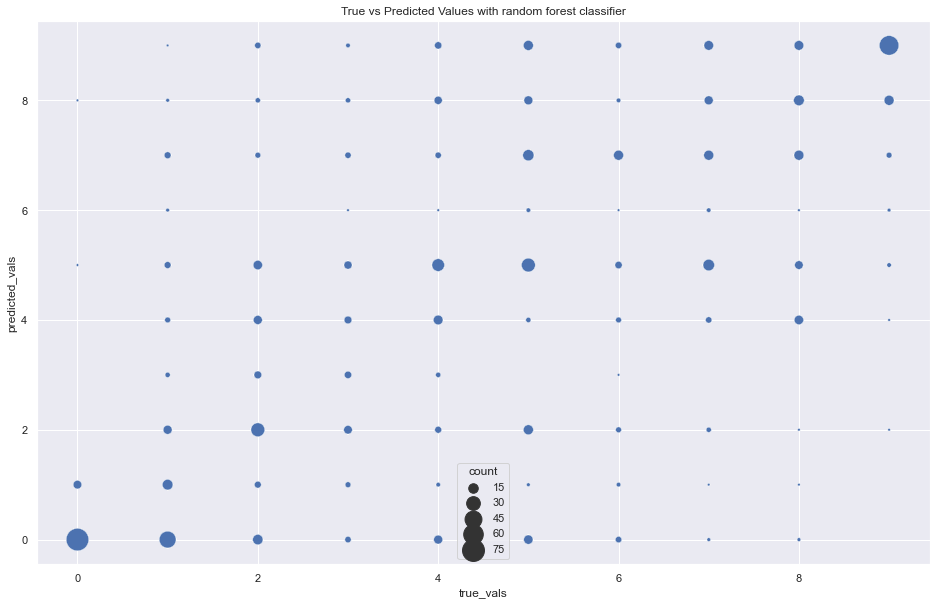

In [37]:
sns.scatterplot(x='true_vals', y='predicted_vals',
             data = plotting_data, size='count', sizes=(0, 500)
             ).set_title('True vs Predicted Values with random forest classifier')
None

Most predictions do seem to be pretty close to their true value. Obviously, some are very far off, but the accuracy achieved is surprisingly good for how little data we have.

## Regression Modeling

Now I will try to solve the same problem with a slightly different approach. I will treat the problem as regression rather than classification, still trying to predict a player's transfer fee. Note, I will need to use slightly different metrics to evaluate these models because the 'Mean Relative Accuracy' from the classification problems is no longer applicable due to this being a regression problem rather than classification into 10 different categories. The scoring that I have chosen to use is the classic R Squared metric for regression. I have also included information about the explained variance in each outer fold. Other than that, the cross validation process is very similar to what it was when performing classification.

In [38]:
reg_season_le = LabelEncoder()
class_df['Season'] = reg_season_le.fit_transform(class_df['Season'])

class_df.sort_values('Season')

,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee
0,Right Midfield,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,0,60000000
157,Left Midfield,23,Atlético Madrid,LaLiga2,Real Madrid,LaLiga,0,3500000
158,Defensive Midfield,24,Hamburger SV,1.Bundesliga,Everton,Premier League,0,3500000
159,Centre-Forward,23,Busan IPark,"Korea, South",Perugia,Serie A,0,3500000
160,Attacking Midfield,27,Sevilla FC,LaLiga2,AEK Athens,Super League,0,3500000
...,...,...,...,...,...,...,...,...
4541,Left Midfield,23,Norwich,Championship,Cardiff,Premier League,18,11400000
4542,Attacking Midfield,25,Bristol City,Championship,Cardiff,Premier League,18,11350000
4543,Attacking Midfield,20,Sheffield Utd.,Championship,Bournemouth,Premier League,18,11300000
4545,Right Midfield,26,Huddersfield,Premier League,Stoke City,Championship,18,11200000


In [39]:
#Performing one-hot encoding on Position, Team_from, League_from, Team_to, and League_to

Y, X = pts.dmatrices('Transfer_fee ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = class_df,
                    return_type='dataframe')

np_Y = Y['Transfer_fee'].to_numpy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
X.head()

,Intercept,C(Position)[T.Central Midfield],C(Position)[T.Centre-Back],C(Position)[T.Centre-Forward],C(Position)[T.Defensive Midfield],C(Position)[T.Goalkeeper],C(Position)[T.Left Midfield],C(Position)[T.Left-Back],C(Position)[T.Right Midfield],C(Position)[T.Right-Back],...,C(League_to)[T.Stars League],C(League_to)[T.Super League],C(League_to)[T.SuperLiga],C(League_to)[T.Superligaen],C(League_to)[T.Série A],C(League_to)[T.Süper Lig],C(League_to)[T.Torneo Final],C(League_to)[T.UAE Gulf League],Age,Season
0,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,-0.285402,-0.224231,3.430997,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
1,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.204700,-1.645154
2,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,3.503832,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
3,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,2.062018,-1.645154
4,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,-1.033512,-1.645154


In [40]:
X_train, X_test, y_train, y_test = train_test_split( X, np_Y, test_size=0.2, random_state=23)

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
def reg_scorer(y_true, y_pred, is_training=True):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    '''
    print("originalclass")
    print(originalclass)
    print("predictedclass")
    print(predictedclass)
    '''
    # Custom Accuracy function to measure the distance of the predicted value from the true value rather than a simple
    # accuracy score that only determines if the datapoint was correctly classified or not
    exp_var = explained_variance_score(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if is_training:
        print("Explained Variance of this outer fold is: ")
        print(exp_var)
        print("The R2 of this outer fold is: ")
        print(r2)
    return r2

def run_reg_model(model, parameters, X, y):
    clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs = -1)
    clf.fit(X, y)
    nested_r2 = cross_val_score(model, X=X, y=y, scoring=make_scorer(reg_scorer), verbose=3).mean()
    return clf.best_params_, nested_r2

## Model Selection

Now I have prepared my training and testing datasets similarly to before and written a custom regression scoring function. Let's compare the various regression models.

#### KNN Regressor

In [42]:
from sklearn.neighbors import KNeighborsRegressor
params = {
    'n_neighbors': np.arange(3, 16),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

originalclass = []
predictedclass = []

rknn_best_params, rknn_nested_score = run_reg_model(KNeighborsRegressor(n_jobs = -1), params, X_train, y_train)
print("The best parameters are: ")
print(rknn_best_params)
print("Mean r squared of all outer folds is: ")
print(rknn_nested_score)

test_model = KNeighborsRegressor(n_neighbors=rknn_best_params['n_neighbors'],
                                  weights=rknn_best_params['weights'],
                                  metric=rknn_best_params['metric'],
                                  n_jobs = -1).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
-0.1817561913683461
The R2 of this outer fold is: 
-0.27081315217402024
[CV] END ............................... score: (test=-0.271) total time=   0.2s
Explained Variance of this outer fold is: 
0.050448153041256605
The R2 of this outer fold is: 
0.0003667829881583984
[CV] END ................................ score: (test=0.000) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


Explained Variance of this outer fold is: 
-0.04437572009403001
The R2 of this outer fold is: 
-0.1311301950953807
[CV] END ............................... score: (test=-0.131) total time=   0.2s
Explained Variance of this outer fold is: 
-0.008762301897099478
The R2 of this outer fold is: 
-0.049942968236491136
[CV] END ............................... score: (test=-0.050) total time=   0.2s
Explained Variance of this outer fold is: 
-0.452933640600268
The R2 of this outer fold is: 
-0.7282773376972558
[CV] END ............................... score: (test=-0.728) total time=   0.2s
The best parameters are: 
{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Mean r squared of all outer folds is: 
-0.23595937404299788
The r squared on the test dataset is: 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


-0.05521216482953273


#### Linear Regressor

In [43]:
from sklearn.linear_model import LinearRegression

originalclass = []
predictedclass = []
#Note there are no parameters to optimize for Linear Regression
_ , rlr_nested_score = run_reg_model(LinearRegression(), {}, X_train, y_train)
print("Mean r squared of all outer folds is: ")
print(rlr_nested_score)

test_model = LinearRegression().fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
-3.131901606994099e+28
The R2 of this outer fold is: 
-3.132507019177874e+28
[CV] END ... score: (test=-31325070191778738790148866048.000) total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


Explained Variance of this outer fold is: 
-3.046767324440288e+28
The R2 of this outer fold is: 
-3.0507405237411085e+28
[CV] END ... score: (test=-30507405237411085286232817664.000) total time=   0.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


Explained Variance of this outer fold is: 
-2.1100450830669877e+28
The R2 of this outer fold is: 
-2.1148493486540672e+28
[CV] END ... score: (test=-21148493486540672208809754624.000) total time=   0.4s
Explained Variance of this outer fold is: 
-1.9725058659260144e+28
The R2 of this outer fold is: 
-1.9754110756270493e+28
[CV] END ... score: (test=-19754110756270493082924875776.000) total time=   0.4s
Explained Variance of this outer fold is: 
-7.605559975500181e+28
The R2 of this outer fold is: 
-7.607516355561761e+28
[CV] END ... score: (test=-76075163555617608687813656576.000) total time=   0.4s
Mean r squared of all outer folds is: 
-3.576204864552372e+28


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


The r squared on the test dataset is: 
-2.3731710499587237e+28


#### Decision Tree Regressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

params = {'max_depth': range(1, 11),
          'min_samples_split': range(10, 60, 10)
}
originalclass = []
predictedclass = []

rdt_best_params, rdt_nested_score = run_reg_model(DecisionTreeRegressor(), params, X_train, y_train)
print("The best parameters are: ")
print(rdt_best_params)
print("Mean r squared of all outer folds is: ")
print(rdt_nested_score)

test_model = DecisionTreeRegressor(max_depth=rdt_best_params['max_depth'],
                                  min_samples_split=rdt_best_params['min_samples_split']).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

/Users/jarrettbrunner/miniconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.001077868694062678
The R2 of this outer fold is: 
-0.011855568745091638
[CV] END ............................... score: (test=-0.012) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


Explained Variance of this outer fold is: 
0.07509413581816493
The R2 of this outer fold is: 
0.06726752710740036
[CV] END ................................ score: (test=0.067) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


Explained Variance of this outer fold is: 
-0.05838898907601986
The R2 of this outer fold is: 
-0.060285860372569555
[CV] END ............................... score: (test=-0.060) total time=   0.3s
Explained Variance of this outer fold is: 
-0.10262455817205329
The R2 of this outer fold is: 
-0.11176802616324744
[CV] END ............................... score: (test=-0.112) total time=   0.3s
Explained Variance of this outer fold is: 
-0.05139187153799485
The R2 of this outer fold is: 
-0.05438673423412954
[CV] END ............................... score: (test=-0.054) total time=   0.3s
The best parameters are: 
{'max_depth': 10, 'min_samples_split': 50}
Mean r squared of all outer folds is: 
-0.03420573248152756
The r squared on the test dataset is: 
0.30901309606355787


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


#### Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor


params = {
    'bootstrap': [True],
    'max_depth': [10, 50],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [200, 1000]
}


originalclass = []
predictedclass = []

rrf_best_params, rrf_nested_score = run_reg_model(RandomForestRegressor(n_jobs = -1), params, X_train, y_train)
print("The best parameters are: ")
print(rrf_best_params)
print("Mean r squared of all outer folds is: ")
print(rrf_nested_score)

test_model = RandomForestRegressor(bootstrap=rrf_best_params['bootstrap'],
                                  max_depth=rrf_best_params['max_depth'],
                                  max_features=rrf_best_params['max_features'],
                                  n_estimators=rrf_best_params['n_estimators'],
                                  n_jobs = -1).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.3576710679533307
The R2 of this outer fold is: 
0.34978063337483734
[CV] END ................................ score: (test=0.350) total time=   7.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


Explained Variance of this outer fold is: 
0.35536387823967186
The R2 of this outer fold is: 
0.3489073947125245
[CV] END ................................ score: (test=0.349) total time=   7.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s


Explained Variance of this outer fold is: 
0.2693106057080349
The R2 of this outer fold is: 
0.2672742587883862
[CV] END ................................ score: (test=0.267) total time=   7.7s
Explained Variance of this outer fold is: 
0.35707509258638215
The R2 of this outer fold is: 
0.3487129523901078
[CV] END ................................ score: (test=0.349) total time=   7.6s
Explained Variance of this outer fold is: 
0.39833877353341895
The R2 of this outer fold is: 
0.39794157748922887
[CV] END ................................ score: (test=0.398) total time=   7.2s
The best parameters are: 
{'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 1000}
Mean r squared of all outer folds is: 
0.3425233633510169


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.0s finished


The r squared on the test dataset is: 
0.3139591415876605


#### Lasso Regression

In [46]:
from sklearn.linear_model import Lasso

params = {
    'alpha' : np.arange(0, 1, 0.1)
}


originalclass = []
predictedclass = []

rlm_best_params, rlm_nested_score = run_reg_model(Lasso(), params, X_train, y_train)
print("The best parameters are: ")
print(rlm_best_params)
print("Mean r squared of all outer folds is: ")
print(rlm_nested_score)

test_model = Lasso(alpha=rlm_best_params['alpha']).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.25992610731383314
The R2 of this outer fold is: 
0.2573756399474405
[CV] END ................................ score: (test=0.257) total time=   2.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


Explained Variance of this outer fold is: 
0.3038445723965032
The R2 of this outer fold is: 
0.30344542875728286
[CV] END ................................ score: (test=0.303) total time=   2.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


Explained Variance of this outer fold is: 
0.14344342037552626
The R2 of this outer fold is: 
0.14209500521064067
[CV] END ................................ score: (test=0.142) total time=   2.8s
Explained Variance of this outer fold is: 
0.33454273821820424
The R2 of this outer fold is: 
0.33336747861064686
[CV] END ................................ score: (test=0.333) total time=   2.7s
Explained Variance of this outer fold is: 
0.11549449447807247
The R2 of this outer fold is: 
0.10487440959572736
[CV] END ................................ score: (test=0.105) total time=   2.5s
The best parameters are: 
{'alpha': 0.9}
Mean r squared of all outer folds is: 
0.2282315924243476


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.4s finished


The r squared on the test dataset is: 
0.2599573877665836


#### Elastic Net Regression

In [47]:
from sklearn.linear_model import ElasticNet


params = {
    'alpha' : np.arange(0, 1, 0.1)
}


originalclass = []
predictedclass = []

ren_best_params, ren_nested_score = run_reg_model(ElasticNet(), params, X_train, y_train)
print("The best parameters are: ")
print(ren_best_params)
print("Mean r squared of all outer folds is: ")
print(ren_nested_score)

test_model = ElasticNet(alpha=ren_best_params['alpha']).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.32146767839687307
The R2 of this outer fold is: 
0.31952201645973266
[CV] END ................................ score: (test=0.320) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Explained Variance of this outer fold is: 
0.30926027780851106
The R2 of this outer fold is: 
0.30911735441081045
[CV] END ................................ score: (test=0.309) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


Explained Variance of this outer fold is: 
0.22944962921316003
The R2 of this outer fold is: 
0.22784273227408536
[CV] END ................................ score: (test=0.228) total time=   0.3s
Explained Variance of this outer fold is: 
0.3513590655812793
The R2 of this outer fold is: 
0.34991758103033765
[CV] END ................................ score: (test=0.350) total time=   0.2s
Explained Variance of this outer fold is: 
0.3348139809487163
The R2 of this outer fold is: 
0.31827191285389966
[CV] END ................................ score: (test=0.318) total time=   0.2s
The best parameters are: 
{'alpha': 0.7000000000000001}
Mean r squared of all outer folds is: 
0.3049343194057732


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


The r squared on the test dataset is: 
0.285552494348429


#### RF Regressor Visualization

It was close, but it looks like the best regression model is the Random Forest. I will now make a graph for the true vs predicted values similarl to the one I made for the classification.

In [48]:
test_model = RandomForestRegressor(bootstrap=rrf_best_params['bootstrap'],
                                    max_depth=rrf_best_params['max_depth'],
                                    max_features=rrf_best_params['max_features'],
                                    n_estimators=rrf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
plotting_data = pd.DataFrame({'true_vals': y_test, 'predicted_vals': test_model.predict(X_test)})

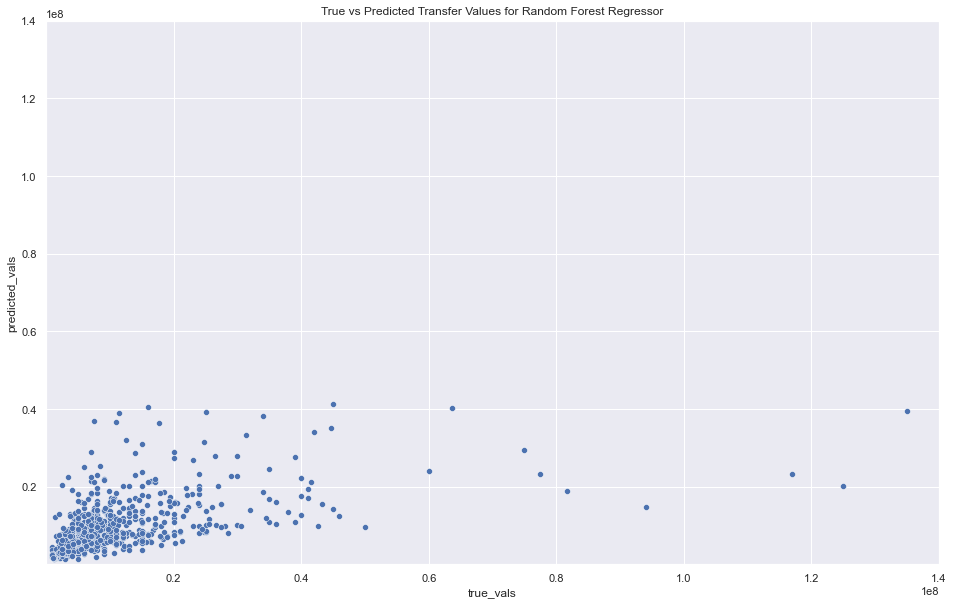

In [49]:
fig, ax = plt.subplots()
sns.scatterplot(x='true_vals', y='predicted_vals',
             data = plotting_data, ax=ax).set_title('True vs Predicted Transfer Values for Random Forest Regressor')

ax.set_xlim(1,1.4e8)
ax.set_ylim(1,1.4e8)
plt.show()
None

As we can see the data does seem to generally follow the line of x=y, which is what we were hoping for. It should be noted that our regression is definitely skewed towards predicting lower transfer fees than what happens in reality, as a number of true values are over 0.4e8 (40 million), while our model only predicts 3 transfers to be over 40 million. I'll do another plot that doesn't include some of the outliers to get a better picture of what is happening with the majority of the data.

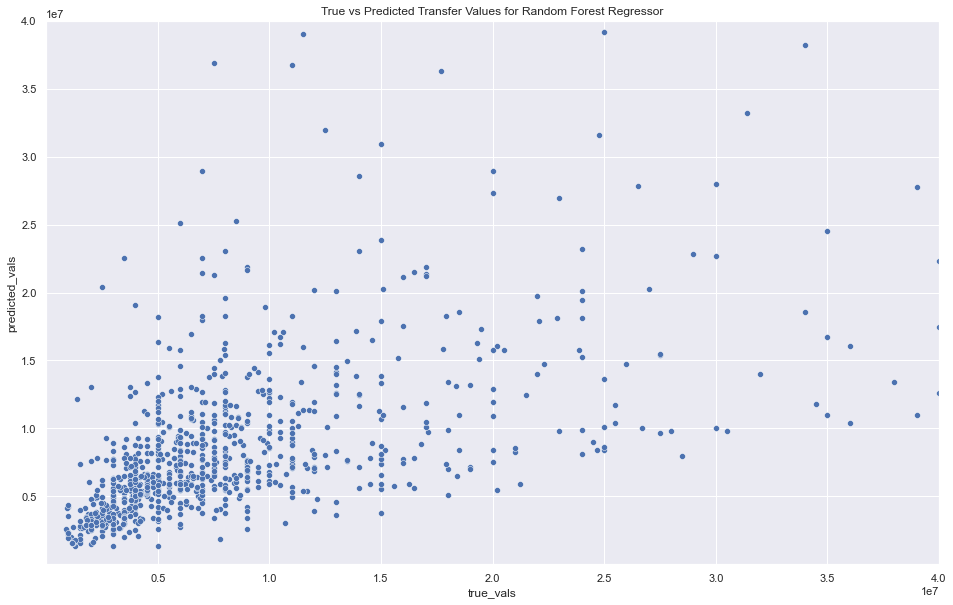

In [50]:
fig, ax = plt.subplots()
sns.scatterplot(x='true_vals', y='predicted_vals',
             data = plotting_data, ax=ax).set_title('True vs Predicted Transfer Values for Random Forest Regressor')

ax.set_xlim(1,0.4e8)
ax.set_ylim(1,0.4e8)
plt.show()
None

This graph confirms our previous suspicions. The model performs really well in predicting transfers with very low transfer fees, but the predictions begin to vary more as the true value of the transfer increases.

## Trying a Time Series Split

In all of our previous ML models, we used a standard Train_Test_Split method to create training and testing datasets. This however, may not be the best method for this dataset, because it could be argued that these transfers are a time series of approximately twenty seasons. Thus, I will use the two best models from the previous sections (Random Forest Classifier and Random Forest Regressor) and train them using a TimeSeriesSplit.

In [51]:
unique_seasons = bucketed_df['Season'].nunique()
bucketed_df.sort_values('Season')
Y, X = pts.dmatrices('bucket ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = bucketed_df,
                    return_type='dataframe')
np_Y = Y['bucket'].to_numpy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [52]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=unique_seasons - 1)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = np_Y[train_index], np_Y[test_index]
    model = RandomForestClassifier(bootstrap=rf_best_params['bootstrap'],
                                    max_depth=rf_best_params['max_depth'],
                                    max_features=rf_best_params['max_features'],
                                    n_estimators=rf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
    yhat = model.predict(X_test)
    custom_classification_scoring(y_test, yhat)
    

Mean Relative Accuracy of this outer fold is: 
0.520242914979757
Mean Relative Accuracy of this outer fold is: 
0.7497975708502026
Mean Relative Accuracy of this outer fold is: 
0.8352226720647774
Mean Relative Accuracy of this outer fold is: 
0.7886639676113361
Mean Relative Accuracy of this outer fold is: 
0.7704453441295546
Mean Relative Accuracy of this outer fold is: 
0.7388663967611337
Mean Relative Accuracy of this outer fold is: 
0.6979757085020243
Mean Relative Accuracy of this outer fold is: 
0.7834008097165992
Mean Relative Accuracy of this outer fold is: 
0.7902834008097168
Mean Relative Accuracy of this outer fold is: 
0.7931174089068828
Mean Relative Accuracy of this outer fold is: 
0.7789473684210526
Mean Relative Accuracy of this outer fold is: 
0.7963562753036437
Mean Relative Accuracy of this outer fold is: 
0.7607287449392713
Mean Relative Accuracy of this outer fold is: 
0.817004048582996
Mean Relative Accuracy of this outer fold is: 
0.7680161943319839
Mean Relativ

As we can see in the later folds (in which the model is trained on most of the data and then tested on the later years), the TimeSeriesSplit is actually slightly better for Random Forest Classifier than the normal TrainTestSplit is. Now we will do the same thing, but with Random Forest Regression.

In [53]:
Y, X = pts.dmatrices('Transfer_fee ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = class_df,
                    return_type='dataframe')

np_Y = Y['Transfer_fee'].to_numpy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [54]:
tscv = TimeSeriesSplit(n_splits=unique_seasons - 1)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = np_Y[train_index], np_Y[test_index]
    model = RandomForestRegressor(bootstrap=rrf_best_params['bootstrap'],
                                    max_depth=rrf_best_params['max_depth'],
                                    max_features=rrf_best_params['max_features'],
                                    n_estimators=rrf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
    yhat = model.predict(X_test)
    reg_scorer(y_test, yhat)
    

Explained Variance of this outer fold is: 
-0.009776926651279272
The R2 of this outer fold is: 
-28.117841915766085
Explained Variance of this outer fold is: 
0.1439653102800994
The R2 of this outer fold is: 
-15.600257786642462
Explained Variance of this outer fold is: 
0.23656708868747967
The R2 of this outer fold is: 
-4.634748590990988
Explained Variance of this outer fold is: 
-0.31061217115911366
The R2 of this outer fold is: 
-8.241972291902972
Explained Variance of this outer fold is: 
0.03934795132908886
The R2 of this outer fold is: 
-4.51701295332614
Explained Variance of this outer fold is: 
-0.0016229637137128439
The R2 of this outer fold is: 
-5.817129732839621
Explained Variance of this outer fold is: 
-0.5337950481547977
The R2 of this outer fold is: 
-8.474278877463993
Explained Variance of this outer fold is: 
-0.167317359350851
The R2 of this outer fold is: 
-4.684858732721283
Explained Variance of this outer fold is: 
0.08334667248033123
The R2 of this outer fold is

Interestingly enough, the Random Forest Regression performed significantly worse on the TimeSeriesSplit data in comparison to the TrainTestSplit data. I would stick with normal TrainTestSplit if I were to use regression going forward.

## Further Improvements / Next Steps

If I really wanted to make this model the best that it could possibly be, there are a number of further experiments that I could perform. I could perform some feature selection or PCA to see if a simpler input dataset can allow the model to achieve greater accuracy. I could also perform further hyperparameter optimization by both making the initial grid search larger and also including a second grid search to look over a range of hyperparameters surrounding the best ones from the original grid search. I would also compare a TimeSeriesSplit to TrainTestSplit for every single model rather than just the best ones with TrainTestSplit. Finally, I would also try to augment this dataset with more data from the last couple of seasons and just more data overall. The model could probably achieve a significant amount of improvement with all of these steps.